In [1]:
import pandas as pd
import os
import numpy as np
from collections import Counter
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sc 

In [2]:
# Set these so that basefolder is the folder containing the cleaned data folder
# and plotsfolder being the folder to save the plots in
basefolder = ''
plotsfolder = 'plots'
cleaned_data_folder = 'cleaned data'
outfolder = 'TCRs_for_clustering'

In [3]:
### Function definitions
def determine_disease(row):
    if row['GCA Status'] == 1:
        disease = 'GCA'
    elif row['PNH Status'] == 1 or row['AA Status'] == 1:
        disease = 'Control'
    elif row['Health Status'] == 1:
        disease = 'Control'
    return disease

In [4]:
# Order samples by group
metadata = pd.read_csv(os.path.join(basefolder, 'all_sample_metadata.csv'))
metadata = metadata[~metadata['Age'].isin(['Unknown', 'nk'])]
metadata['Age'] = metadata['Age'].apply(lambda x: int(x))
metadata['Disease'] = [determine_disease(x) for i,x in metadata.iterrows()]
gDNA_data = metadata[metadata['gDNA'] == 1]
metadata_gDNA_GCA = gDNA_data[gDNA_data['GCA Status']==1]
np.min(metadata_gDNA_GCA['Age'])

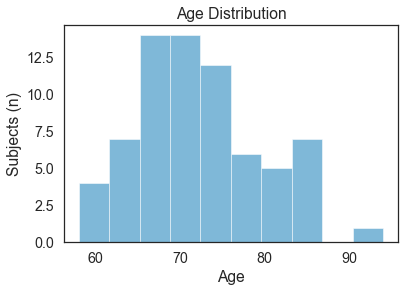

In [6]:
sns.set_theme(style="white", palette="colorblind", font_scale=1.3)
plt.hist(gDNA_data[gDNA_data['GCA Status'] == 1]['Age'], alpha=0.5)
plt.title('Age Distribution')
plt.ylabel('Subjects (n)')
plt.xlabel('Age')
plt.savefig(os.path.join(basefolder,plotsfolder,'age_distribution_GCAgDNA.pdf'))

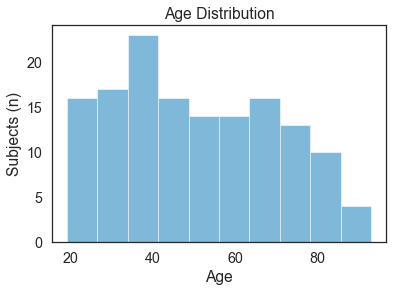

In [7]:
plt.hist(gDNA_data[gDNA_data['Control Status'] == 1]['Age'], alpha=0.5)
plt.title('Age Distribution')
plt.ylabel('Subjects (n)')
plt.xlabel('Age')
plt.savefig(os.path.join(basefolder,plotsfolder,'age_distribution_controls.pdf'))

In [30]:
# To match ages, use only controls over 55 years old
controls = metadata[metadata['Control Status'] == 1]
c = controls[controls['Age'] >= 55]
c.to_csv(os.path.join(basefolder,outfolder,'agematched_control_files.csv'))
print('Control subjects over 55: ',len(c))
print('GCA subjects with known age: ',len(gDNA_data[gDNA_data['GCA Status'] == 1]))

Control subjects over 55:  60
GCA subjects with known age:  70


Controls: Median age 69.5 pm 15.5
GCA: Median age 72.0 pm 9.0
MannwhitneyuResult(statistic=2427.0, pvalue=0.12689890946710763)


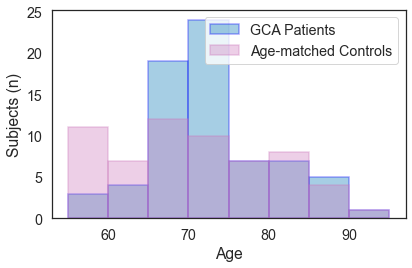

In [31]:

control_age = np.median(c['Age'])
control_age_std = sc.iqr(c['Age'])
print(f'Controls: Median age {control_age} pm {control_age_std}')
gca_age = np.median(gDNA_data[gDNA_data['GCA Status'] == 1]['Age'])
gca_age_std = sc.iqr(gDNA_data[gDNA_data['GCA Status'] == 1]['Age'])
print(f'GCA: Median age {gca_age} pm {gca_age_std}')

print(sc.mannwhitneyu(gDNA_data[gDNA_data['GCA Status'] == 1]['Age'], c['Age']))

plt.hist(gDNA_data[gDNA_data['GCA Status'] == 1]['Age'], alpha=0.35, linewidth=1.5, edgecolor='blue', label='GCA Patients',bins=[55, 60,65, 70, 75, 80, 85, 90, 95])
plt.hist(c['Age'], alpha=0.35, linewidth=1.5, edgecolor='#cc78bc', color='#cc78bc', label='Age-matched Controls',bins=[55, 60,65, 70, 75, 80, 85, 90, 95])

plt.legend()
#plt.title('Age Distribution')
plt.ylabel('Subjects (n)')
plt.xlabel('Age')
plt.yticks([0,5,10,15,20,25])
plt.tight_layout()
plt.savefig(os.path.join(basefolder,plotsfolder,'age_distribution_agematched.pdf'))

In [32]:
def isitin(row):
    if row['Name'] in set(c['Name']) or row['GCA Status'] == 1:
        return 1
    else:
        return 0
gDNA_data['Agematched included'] = [isitin(x) for i,x in gDNA_data.iterrows()]
agematched = gDNA_data[gDNA_data['Agematched included']==1]

/Users/wbr/opt/anaconda3/envs/leeds/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


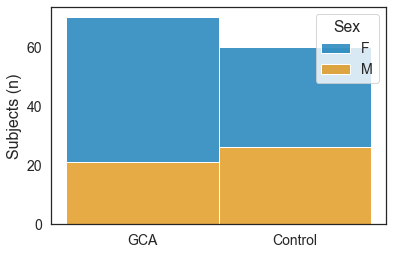

In [13]:
# Dataset Overview Plots
fig, ax = plt.subplots()

# Plot Data
sns.histplot(x=agematched['Disease'], hue=agematched['Sex'], multiple='stack', legend=True)
# Style
ax.set_ylabel('Subjects (n)',fontsize=16)
ax.tick_params(labelsize=14)                                     
ax.set_xlabel('')
plt.savefig(os.path.join(basefolder, plotsfolder,'agematched_samples_per_sex.pdf'))

In [14]:
gca = agematched[agematched['Disease'] == 'GCA']
control = agematched[agematched['Disease'] == 'Control']
print('F to M ration GCA: ', len(gca[gca['Sex'] == 'F'])/len(gca))
print('F to M ration agematched Controls: ', len(control[control['Sex'] == 'F'])/len(control))

F to M ration GCA:  0.7
F to M ration agematched Controls:  0.5666666666666667


In [15]:
### Print out Infos
print('# Total Control samples: ', len(c))
print('# Healthy Control samples: ', len(c[c['Health Status'] ==1]))
print('# PNH Control samples: ', len(c[c['PNH Status'] ==1]))
print('# AA Control samples: ', len(c[c['AA Status'] ==1]))

# Total Control samples:  60
# Healthy Control samples:  36
# PNH Control samples:  14
# AA Control samples:  10


In [16]:
c_without_PNH_AA =  c[c['Health Status'] ==1]
c_without_PNH_AA.to_csv(os.path.join(basefolder,outfolder,'healthy_controls_agematched.csv'))

Controls: Median age  71.5 pm 17.25
GCA: Median Age  72.0 pm 9.0
MannwhitneyuResult(statistic=1272.0, pvalue=0.9387706945481408)


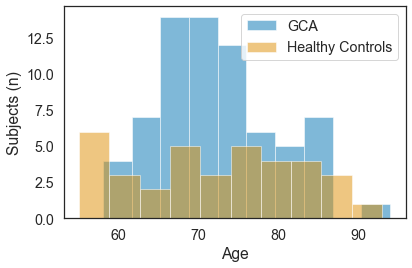

In [34]:
print('Controls: Median age ', np.median(c_without_PNH_AA['Age']),'pm', sc.iqr(c_without_PNH_AA['Age']))
print('GCA: Median Age ', np.median(gDNA_data[gDNA_data['GCA Status'] == 1]['Age']),'pm', sc.iqr(gDNA_data[gDNA_data['GCA Status'] == 1]['Age']))

print(sc.mannwhitneyu(gDNA_data[gDNA_data['GCA Status'] == 1]['Age'], c_without_PNH_AA['Age']))

plt.hist(gDNA_data[gDNA_data['GCA Status'] == 1]['Age'], alpha=0.5, label='GCA')
plt.hist(c_without_PNH_AA['Age'], alpha=0.5, label='Healthy Controls')

plt.legend()
plt.ylabel('Subjects (n)')
plt.xlabel('Age')
plt.tight_layout()
plt.savefig(os.path.join(basefolder,plotsfolder,'age_distribution_agematched_healthy.pdf'))

In [20]:
# V segment Cleanup
# In case that two V segments are listed, take the first one (more probable)
def decide_segment(seg):
    seg_tuple = seg.split(',')
    if len(seg_tuple) != 1:
        return seg_tuple[0]
    else:
        return seg
# In case of these four segment variants replace with variant contained in database
def swap_problematic_vseg(vseg):
    swap = {
        'TRBV21-1*02': 'TRBV21-1*01',
        'TRBV24-1*02': 'TRBV24-1*01',
        'TRBV11-3*04': 'TRBV11-3*01', 
        'TRBV5-2*01': 'TRBV5-1*01',
    }
    if vseg in swap.keys():
        return swap[vseg]
    else:
        return vseg

def cleanup(df):
    df_cleaned = df.drop_duplicates(subset='aaSeqCDR3')
    # rename columns
    df_cleaned = df_cleaned.rename(columns={
        'aaSeqCDR3': 'cdr3_b_aa',
        'bestVHit': 'v_b_gene',
        'bestJHit': 'j_b_gene'})
    df_cleaned['v_b_gene'] = df_cleaned['v_b_gene'].apply(lambda x: decide_segment(x))
    df_cleaned['v_b_gene'] = df_cleaned['v_b_gene'].apply(lambda x: swap_problematic_vseg(x))
    # retain only sequences with TRBV segments
    df_cleaned = df_cleaned[df_cleaned['v_b_gene'].str.contains('TRBV')]
    # remove sequences with this segment, as it does not exist in database
    df_cleaned = df_cleaned[df_cleaned['v_b_gene'] != 'TRBV7-5*01']
    return df_cleaned

In [21]:
# Get only TCRs with at least 10 reads for clustering
cutoff=10

In [22]:
# Get all Control TCRs
agematched_controls = pd.DataFrame()

for name in c['Name']:
    #print(name)
    for filename in glob.glob(
        os.path.join(basefolder, cleaned_data_folder, name+'*_cleaned_2.txt')
        ):
        sample = pd.read_csv(
            filename,
            usecols=['cloneCount', 'cloneFraction', 'aaSeqCDR3', 'bestVHit', 'bestJHit']
        )
        sample = sample[sample['cloneCount'] >= cutoff] 
        #print(filename, len(sample))
        sample['Name'] = [filename.split('/')[-1].split('_')[0] for i in range(len(sample))]
        sample['GCA'] = [0 for i in range(len(sample))]
        agematched_controls = pd.concat([agematched_controls, sample])
agematched_controls_cleaned = cleanup(agematched_controls)
#agematched_controls_cleaned.to_csv(os.path.join(basefolder, outfolder, 'agematched_control_tcrs_clean.csv'), index=False)

In [23]:
# Get only healthy control TCRs
agematched_healthy_controls = pd.DataFrame()

for name in c_without_PNH_AA['Name']:
    #print(name)
    for filename in glob.glob(
        os.path.join(basefolder, cleaned_data_folder, name+'*_cleaned_2.txt')
        ):
        sample = pd.read_csv(
            filename,
            usecols=['cloneCount', 'cloneFraction', 'aaSeqCDR3', 'bestVHit', 'bestJHit']
        )
        sample = sample[sample['cloneCount'] >= cutoff] 
        #print(filename, len(sample))
        sample['Name'] = [filename.split('/')[-1].split('_')[0] for i in range(len(sample))]
        sample['GCA'] = [0 for i in range(len(sample))]
        agematched_healthy_controls = pd.concat([agematched_healthy_controls, sample])
agematched_healthy_controls_cleaned = cleanup(agematched_healthy_controls)
#agematched_healthy_controls_cleaned.to_csv(os.path.join(basefolder, outfolder, 'agematched_healthy_control_tcrs_clean.csv'), index=False)

In [24]:
# Get non agematched controls
all_controls = pd.DataFrame()
for name in gDNA_data[gDNA_data['Control Status'] == 1]['Name']:
    for filename in glob.glob(
        os.path.join(basefolder, cleaned_data_folder, name+'*_cleaned_2.txt')
        ):
        sample = pd.read_csv(
            filename,
            usecols=['cloneCount', 'cloneFraction', 'aaSeqCDR3', 'bestVHit', 'bestJHit']
        )
        sample = sample[sample['cloneCount'] >= cutoff]
        sample['Name'] = [filename.split('/')[-1].split('_')[0] for i in range(len(sample))]
        sample['GCA'] = [0 for i in range(len(sample))]
        all_controls = pd.concat([all_controls, sample])
all_controls_cleaned = cleanup(all_controls)
#all_controls_cleaned.to_csv(os.path.join(basefolder, outfolder, 'control_tcrs_clean.csv'), index=False)

In [25]:
# Get all GCA gDNA TCRs
all_GCA = pd.DataFrame()

for name in gDNA_data[gDNA_data['GCA Status'] == 1]['Name']:
    for filename in glob.glob(
        os.path.join(basefolder, cleaned_data_folder, name+'*_cleaned_2.txt')
        ):
        sample = pd.read_csv(
            filename,
            usecols=['cloneCount', 'cloneFraction', 'aaSeqCDR3', 'bestVHit', 'bestJHit']
        )
        sample = sample[sample['cloneCount'] >= cutoff]
        #print(filename, len(sample))
        sample['Name'] = [filename.split('/')[-1].split('_')[0] for i in range(len(sample))]
        sample['GCA'] = [1 for i in range(len(sample))]
        all_GCA = pd.concat([all_GCA, sample])
all_GCA_cleaned = cleanup(all_GCA)
# Remove all TCRs that occur in any of the controls
all_GCA_cleaned = all_GCA_cleaned[~all_GCA_cleaned['cdr3_b_aa'].isin(all_controls_cleaned['cdr3_b_aa'])]
#all_GCA_cleaned.to_csv(os.path.join(basefolder,outfolder, 'all_GCA_tcrs_clean_nodup.csv'), index=False)

In [26]:
# Print out Info
print('Nr of Agematched control TCRs', len(agematched_controls_cleaned))
print('Nr of Agematched Healthy control TCRs', len(agematched_healthy_controls_cleaned))
print('Nr of all control TCRs', len(all_controls_cleaned))
print('Nr of all GCA TCRs', len(all_GCA_cleaned))

Nr of Agematched control TCRs 72175
Nr of Agematched Healthy control TCRs 41750
Nr of all control TCRs 179214
Nr of all GCA TCRs 67062


In [35]:
# Since 170'000 TCRs for non agematched controls is too much
# We randomly sample 100'000 and discard the rest
all_controls_cleaned_sub = all_controls_cleaned.sample(n=100000)
#all_controls_cleaned_sub.to_csv(os.path.join(basefolder, outfolder, 'control_tcrs_clean_sub.csv'), index=False)

In [29]:
gDNA = metadata[metadata['gDNA'] == 1]
gDNA_gca = gDNA[gDNA['GCA Status'] == 1]
#gDNA_gca.to_csv('/Users/wbr/Library/CloudStorage/OneDrive-UniversityofLeeds/clinical_histo_data/gca_gDNA_ids.csv')